In [229]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError



def data_prep(start_date, end_date):
    df = yf.download('AMZN',start_date,end_date)
    APPL = yf.download('AAPL',start_date,end_date)
    MSFT = yf.download('MSFT',start_date,end_date)
    GOOG = yf.download('GOOG',start_date,end_date)
    VIX = yf.download("^VIX", start_date,end_date)
    usdx = yf.download('DX-Y.NYB', start_date,end_date)


    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df['APPL'] = APPL['Close']
    df['MSFT'] = MSFT['Close']
    df['GOOG'] = GOOG['Close']
    df['VIX'] = VIX['Close']
    df['USDX'] = usdx['Close']

    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()

    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    histogram = macd - signal

    df['EMA12'] = ema12
    df['EMA26'] = ema26
    df['MACD'] = macd
    df['MACD_signal'] = signal
    df['MACD_hist'] = histogram

    print(df.info)
    df.columns = df.columns.str.replace(' ','_')
    df = df.dropna()
    df.drop(['Open', 'High', 'Low', 'Adj_Close'], axis=1, inplace=True)
    y_data = df['Close']
    df.drop(['Close'], axis=1, inplace=True)
    dates = pd.DataFrame(df.index)
    X_data = df
    return X_data,y_data, dates,X_data

start_date = '2022-04-01'
end_date = '2023-03-31'
X, y, dates,X_data = data_prep(start_date, end_date)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

if X.shape[0] > 0 and y.shape[0] > 0:
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
else:
    print("Insufficient data for MinMaxScaler")



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<bound method DataFrame.info of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-04-01  164.149506  165.826996  162.319504  163.559998  163.559998   
2022-04-04  164.125000  168.394501  163.205505  168.346497  168.346497   
2022-04-05  167.741501  168.110504  163.266006  164.054993  164.054993   
2022-04-06  161.650497  162.199997  157.254501  158.755997  158.755997   
2022-04-07  158.399994  160.078995  154.511505  157.784500  157.784500   
...                ...         ...  

In [230]:
dates

,Date
0,2022-04-21
1,2022-04-22
2,2022-04-25
3,2022-04-26
4,2022-04-27
...,...
232,2023-03-24
233,2023-03-27
234,2023-03-28
235,2023-03-29


In [231]:
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_Y, test_Y = y[:train_size], y[train_size:]

# Reshape the input data to 3D arrays
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2
]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss=MeanSquaredError(), optimizer=Adam())


In [232]:
import matplotlib.pyplot as plt


print(X.shape)
print()

(237, 12)



In [233]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model.fit(train_X, train_Y, epochs=100, batch_size=16, validation_data=(test_X, test_Y), callbacks=[early_stop], verbose=2, shuffle=False)

test_loss = model.evaluate(test_X, test_Y, verbose=0)
yhat = model.predict(test_X)

yhat = y_scaler.inverse_transform(yhat)
test_Y = y_scaler.inverse_transform(test_Y)

print('Test loss: ', test_loss)

mae = mean_absolute_error(test_Y, yhat)
rmse = np.sqrt(mean_squared_error(test_Y, yhat))
r2 = r2_score(test_Y, yhat)

print('MAE: ', mae)
print('RMSE: ', rmse)
print('R²: ', r2)

Epoch 1/100
12/12 - 7s - loss: 0.2349 - val_loss: 0.0159 - 7s/epoch - 591ms/step
Epoch 2/100
12/12 - 0s - loss: 0.1214 - val_loss: 0.0144 - 113ms/epoch - 9ms/step
Epoch 3/100
12/12 - 0s - loss: 0.0472 - val_loss: 0.0827 - 120ms/epoch - 10ms/step
Epoch 4/100
12/12 - 0s - loss: 0.0253 - val_loss: 0.0281 - 103ms/epoch - 9ms/step
Epoch 5/100
12/12 - 0s - loss: 0.0294 - val_loss: 0.0299 - 112ms/epoch - 9ms/step
Epoch 6/100
12/12 - 0s - loss: 0.0223 - val_loss: 0.0369 - 105ms/epoch - 9ms/step
Epoch 7/100
12/12 - 0s - loss: 0.0167 - val_loss: 0.0267 - 101ms/epoch - 8ms/step
Epoch 8/100
12/12 - 0s - loss: 0.0136 - val_loss: 0.0254 - 104ms/epoch - 9ms/step
Epoch 9/100
12/12 - 0s - loss: 0.0110 - val_loss: 0.0220 - 103ms/epoch - 9ms/step
Epoch 10/100
12/12 - 0s - loss: 0.0100 - val_loss: 0.0190 - 104ms/epoch - 9ms/step
Epoch 11/100
12/12 - 0s - loss: 0.0080 - val_loss: 0.0136 - 107ms/epoch - 9ms/step
Epoch 12/100
12/12 - 0s - loss: 0.0093 - val_loss: 0.0176 - 103ms/epoch - 9ms/step
Epoch 13/100


In [235]:
def generate_future_features_arima(X_data, n_steps):
    future_features = []
    for i in range(X_data.shape[1]):
        arima_model = pm.auto_arima(X_data.iloc[:, i], suppress_warnings=True, seasonal=False, stepwise=True)
        forecast = arima_model.predict(n_periods=n_steps)
        future_features.append(forecast)
    return np.array(future_features).T

In [253]:
import pandas_market_calendars as mcal
from pandas.tseries.offsets import BDay

def generate_trading_days(start_date, n_days):
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.valid_days(start_date=start_date, end_date=start_date + BDay(n_days * 2))
    return trading_days[:n_days]

n_future_days = 10
last_date = dates.iloc[-1].values[0]
future_dates = generate_trading_days(last_date, n_future_days)


In [254]:
# # Generate future feature values
# n_future_steps = 10
# future_dates = pd.date_range(dates.iloc[-1, 0], periods=n_future_steps + 1, closed='right')

# Get column names from the original DataFrame
column_names = X_data.columns

# Generate future feature values using ARIMA
future_features = generate_future_features_arima(X_data, n_future_days)

# Scale the future feature values
scaled_future_features = scaler.transform(future_features)

# Reshape the future feature values to a 3D array
scaled_future_features = scaled_future_features.reshape((scaled_future_features.shape[0], 1, scaled_future_features.shape[1]))

# Predict future closing prices
future_closing_prices = model.predict(scaled_future_features)

# Inverse transform the predicted closing prices
future_closing_prices = y_scaler.inverse_transform(future_closing_prices)

# Display the future closing prices
future_closing_prices_df = pd.DataFrame(future_closing_prices, index=future_dates, columns=['Predicted_Close'])
print(future_closing_prices_df)


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pr

1/1 [==============================] - 0s 28ms/step
                           Predicted_Close
2023-03-30 00:00:00+00:00       103.923210
2023-03-31 00:00:00+00:00       104.224709
2023-04-03 00:00:00+00:00       104.481895
2023-04-04 00:00:00+00:00       104.701797
2023-04-05 00:00:00+00:00       104.892502
2023-04-06 00:00:00+00:00       105.061668
2023-04-10 00:00:00+00:00       105.215881
2023-04-11 00:00:00+00:00       105.360420
2023-04-12 00:00:00+00:00       105.499420
2023-04-13 00:00:00+00:00       105.635895


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files\Python38\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [257]:
# import pickle

# # Save the model to a file
# with open('lstm_model_VAR.pkl', 'wb') as file:
#     pickle.dump(model, file)

# # Save the MinMaxScaler objects for X and y
# with open('x_scaler_VAR.pkl', 'wb') as file:
#     pickle.dump(scaler, file)

# with open('y_scaler_VAR.pkl', 'wb') as file:
#     pickle.dump(y_scaler, file)


C:\Users\user\AppData\Local\Temp\ipykernel_10796\3753494322.py:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(last_date, periods=n_future_steps + 1, closed='right')


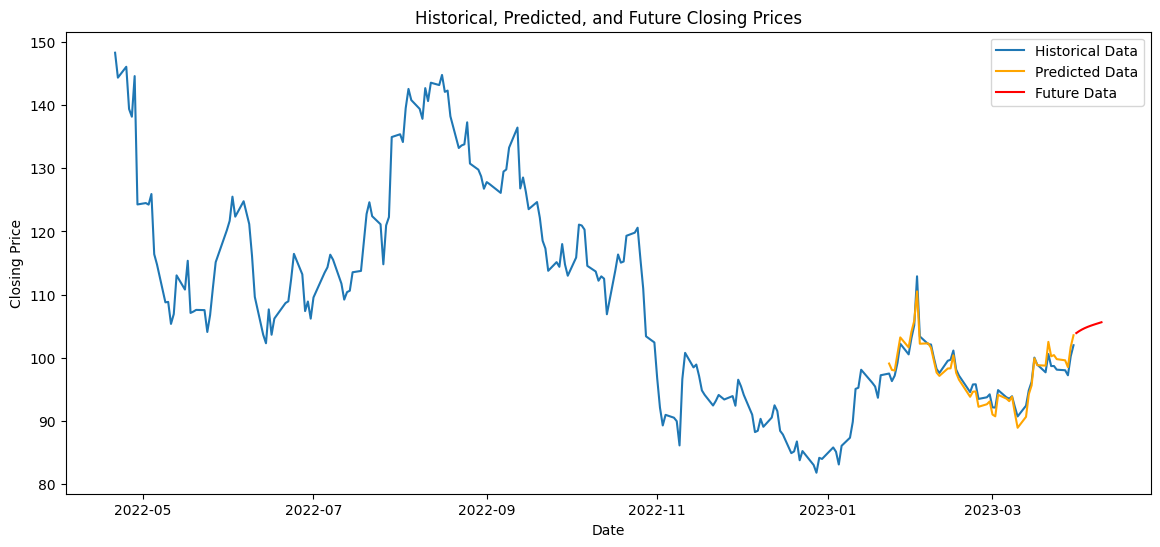

In [258]:
last_date = dates.iloc[-1].values[0]
future_dates = pd.date_range(last_date, periods=n_future_steps + 1, closed='right')

plt.figure(figsize=(14, 6))
plt.plot(dates, y_scaler.inverse_transform(y), label='Historical Data')
plt.plot(dates.iloc[-test_Y.shape[0]:], y_scaler.inverse_transform(test_Y_pred), label='Predicted Data', color='orange')
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Historical, Predicted, and Future Closing Prices')
plt.legend()
plt.show()


2/2 [==============================] - 0s 4ms/step


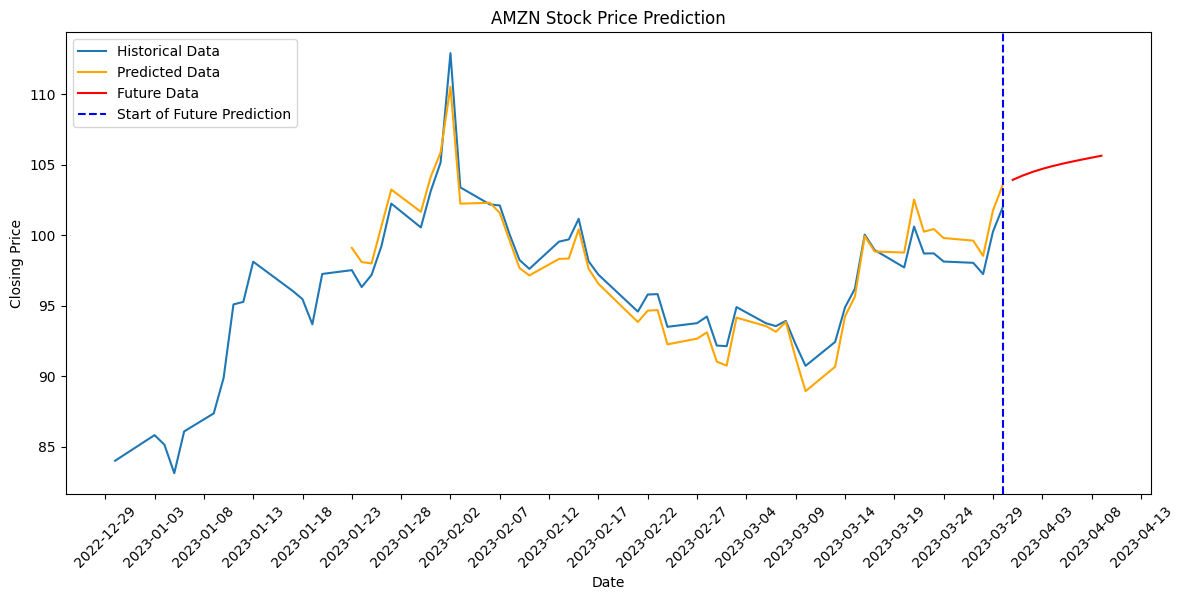

In [259]:
# Predict on the test set
test_Y_pred = model.predict(test_X)

# Filter the data for the last 3 months
n_months = 3
start_date = dates.iloc[-1][0] - pd.DateOffset(months=n_months)
mask = dates['Date'] >= start_date
filtered_dates = dates[mask]
filtered_y = y_scaler.inverse_transform(y)[mask.to_numpy().reshape(-1), :]

# Filter the predicted data
predicted_mask = dates.iloc[-test_Y.shape[0]:]['Date'] >= start_date
filtered_yhat = y_scaler.inverse_transform(test_Y_pred)[predicted_mask]
filtered_predicted_dates = dates.iloc[-test_Y.shape[0]:][predicted_mask]

plt.figure(figsize=(14, 6))
plt.plot(filtered_dates['Date'], filtered_y, label='Historical Data')
plt.plot(filtered_predicted_dates['Date'], filtered_yhat, label='Predicted Data', color='orange')
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red')

# Draw a vertical line at the point of future prediction
plt.axvline(x=dates.iloc[-1][0], color='blue', linestyle='--', label='Start of Future Prediction')

# Display day-by-day dates on the x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AMZN Stock Price Prediction')
plt.legend()
plt.show()
